In [1]:
import arviz as az
import matplotlib.pylab as plt
import matplotlib as mpl
mpl.style.use('plotting.mplstyle')
import numpy as np
np.random.seed(11)
import json
import h5py
import os
from scipy.optimize import minimize
from read_O3_LVK_results import *

In [2]:
# Load AR results
precomputed_data = h5py.File("./../data/ar_lnm1_q_summary.hdf","r")
m1s = precomputed_data['posterior/m1s'][()]
dR_dlnm1s = precomputed_data['posterior/dR_dlnm1s'][()]

## 1. Directly plot results of AR primary mass modeling

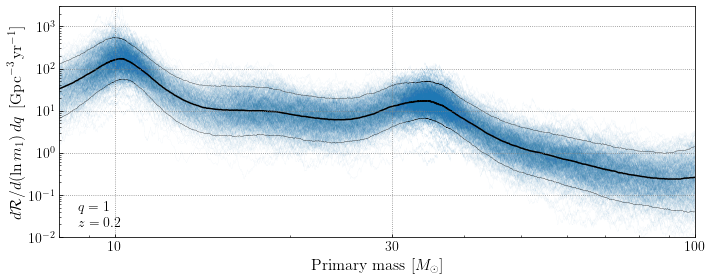

In [3]:
# First make our "trace plot" of AR results
fig,ax = plt.subplots(figsize=(10,4))
ax.set_rasterization_zorder(2)
   
# Plot a random subset of AR samples
for i in np.random.choice(range(dR_dlnm1s.shape[1]),size=500,replace=False):                 
    ax.plot(m1s,dR_dlnm1s[:,i],color='#1f78b4',alpha=0.2,lw=0.1,zorder=0)

# Highlight median and 90% bounds
ax.plot(m1s,np.median(dR_dlnm1s,axis=1),color='black',zorder=1)
ax.plot(m1s,np.quantile(dR_dlnm1s,0.05,axis=1),color='black',lw=0.3,zorder=1)
ax.plot(m1s,np.quantile(dR_dlnm1s,0.95,axis=1),color='black',lw=0.3,zorder=1)

# Misc formatting
ax.tick_params(labelsize=14)
ax.set_xlim(8,100)
ax.set_ylim(1e-2,3e3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([10,30,100])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

# Annotate to show which reference quantities we're using
ax.text(0.03,0.13,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.03,0.06,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

ax.set_xlabel('Primary mass [$M_\odot$]',fontsize=16)
ax.set_ylabel(r'$d\mathcal{R}/d(\ln m_1)\,dq$ \,{[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=16)

plt.tight_layout()
plt.savefig('figure_03a.pdf',bbox_inches='tight',dpi=200)
plt.show()

## 2. Use these results to obtain a representative "best-fit" parametric model

In [4]:
# First, define a parametric model that we think will do a good job capturing the above features

def broken_power_law(m1s,lmbda1,lmbda2,mBreak,mMin,mMax,dmMin):
    
    """
    Helper function defining an unnormalized broken power law
    
    Parameters
    ----------
    m1s : Set of primary masses
    lmbda1 : Power-law index at low masses
    lmbda2 : Power-law index at high masses
    mBreak : Break point at which power-law slope changes
    mMin : Mass below which we will smoothly taper to zero
    mMax : Maximum mass above which our distribution vanishes
    dmMin : Scale over which low-mass tapering is performed
    """
    
    # Define broken power law
    bpl = np.where(m1s<mBreak,(m1s/mBreak)**lmbda1,(m1s/mBreak)**lmbda2)
    
    # Apply smooth tapering below mMin
    tapering = np.exp(-(m1s-mMin)**2/(2.*dmMin**2))
    bpl = np.where(m1s<mMin,bpl*tapering,bpl)
    
    # Set masses above mMax to zero
    bpl[m1s>mMax] = 0
    
    return bpl

def model(m1,f_peak_1,f_peak_2,mu1,sig1,mu2,sig2,lmbda1,lmbda2,mBreak,mMin,mMax,dmMin):
    
    """
    Full expression for our parametric model that we will fit to our AR mass results,
    comprising a broken power law and two Gaussian peaks
    
    Parameters
    ----------
    m1 : Mass values at which to evaluate
    f_peak_1 : Mixture fraction of events occurring in the low-mass peak
    f_peak_2 : Mixture fraction of events occurring in the high-mass peak
    mu1 : Location of low mass peak
    sig1 : Standard deviation of low mass peak
    mu2: Location of high mass peak
    sig1 : Standard deviation of high mass peak
    lmbda1 : Power-law slope below the break
    lmbda2 : Power-law slope above the break
    mBreak : Break point at which power-law slope changes
    mMin : Mass below which the power-law component is smoothly tapered to zero
    mMax : Maximum mass above which our distribution vanishes
    dmMin : Scale over which low-mass tapering is performed
    """
    
    # Define integral over tapered broken power law
    m1_grid = np.linspace(2,100,1000)
    bpl_grid = broken_power_law(m1_grid,lmbda1,lmbda2,mBreak,mMin,mMax,dmMin)
    bpl_norm = np.trapz(bpl_grid,m1_grid)
    
    # Normalized broken (and tapered) power-law
    bpl = broken_power_law(m1,lmbda1,lmbda2,mBreak,mMin,mMax,dmMin)/bpl_norm
    
    # Probability densities corresponding to each peak
    peak_1 = np.exp(-(m1-mu1)**2/(2.*sig1**2))/np.sqrt(2.*np.pi*sig1**2)
    peak_2 = np.exp(-(m1-mu2)**2/(2.*sig2**2))/np.sqrt(2.*np.pi*sig2**2)
    
    # Construct and return full distribution
    p_m1 = f_peak_1*peak_1 + f_peak_2*peak_2 + (1.-f_peak_1-f_peak_2)*bpl
    return p_m1

# Read out the necessary data
# Specifically perform our least-squares fit in the 8-90 Msun range
# Above and below this range, our AR fit reverts to its prior; we don't want our fit here to capture this behavior
# Note also that we will fit dR/dm1, *not* dR/dlnm1
m1s_high = m1s[(m1s>8)*(m1s<90)]
R_m1_target = np.median(dR_dlnm1s,axis=1)[(m1s>8)*(m1s<90)]/m1s_high

# Define least-squares loss function
def ls(params):
    
    # Read tuple of parameters describing mass function
    R_20,f_peak_1,f_peak_2,mu1,sig1,mu2,sig2,lmbda1,lmbda2,mBreak,mMin,mMax,dmMin = params
    
    # Construct the merger rate vs. log-mass corresponding to the proposed choice of parameters
    R_m1_model = model(m1s_high,f_peak_1,f_peak_2,mu1,sig1,mu2,sig2,lmbda1,lmbda2,mBreak,mMin,mMax,dmMin)
    R_m1_model_ref = model(20.,f_peak_1,f_peak_2,mu1,sig1,mu2,sig2,lmbda1,lmbda2,mBreak,mMin,mMax,dmMin)
    R_m1_model = R_m1_model*(R_20/R_m1_model_ref)
    
    # Return the squared residuals between our model and target (log) rates 
    return np.trapz((np.log(R_m1_target)-np.log(R_m1_model))**2,m1s_high)

# Initial guess at model parameters
f_peak_1 = 0.7
f_peak_2 = 0.05
mu1 = 10
sig1 = 1.
mu2 = 34.
sig2 = 3.5
lmbda1 = -2.5
lmbda2 = -4.5
mBreak = 40
mMin = 12.
mMax = 100
dmMin = 1
initial_params = (0.5,f_peak_1,f_peak_2,mu1,sig1,mu2,sig2,lmbda1,lmbda2,mBreak,mMin,mMax,dmMin)

# Fix mMax=100 and bound the allowed range for dmMin
bounds = [(None,None) for param in initial_params]
bounds[2] = (0,1)
bounds[-2] = (100,100)
bounds[-1] = (0.5,10)

# Minimize our error!
soln = minimize(ls,initial_params,method='Nelder-Mead',bounds=bounds,options={'maxiter':1e4})

# Read out solution
fitted_R0,fitted_fp1,fitted_fp2,\
    fitted_mu1,fitted_sig1,fitted_mu2,fitted_sig2,\
    fitted_l1,fitted_l2,fitted_mBreak,fitted_mMin,fitted_mMax,fitted_dmMin = soln.x

In [5]:
# Save our fitting results
with open('./../macros/fitting_results_lnm1.txt','w') as macrofile:
    
    macrofile.write("\\newcommand{{\\MassFitR}}{{{0:.2f}}}".format(fitted_R0))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\MassFitFpeakOne}}{{{0:.2f}}}".format(fitted_fp1))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\MassFitFpeakTwo}}{{{0:.2f}}}".format(fitted_fp2))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\MassFitMuOne}}{{{0:.1f}}}".format(fitted_mu1))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\MassFitSigOne}}{{{0:.1f}}}".format(fitted_sig1))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\MassFitMuTwo}}{{{0:.1f}}}".format(fitted_mu2))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\MassFitSigTwo}}{{{0:.1f}}}".format(fitted_sig2))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\MassFitSlopeOne}}{{{0:.1f}}}".format(fitted_l1))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\MassFitSlopeTwo}}{{{0:.1f}}}".format(fitted_l2))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\MassFitMbreak}}{{{0:.1f}}}".format(fitted_mBreak))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\MassFitMmin}}{{{0:.1f}}}".format(fitted_mMin))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\MassFitMmax}}{{{0:.0f}}}".format(fitted_mMax))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\MassFitDeltaMmin}}{{{0:.1f}}}".format(fitted_dmMin))
    macrofile.write("\n")

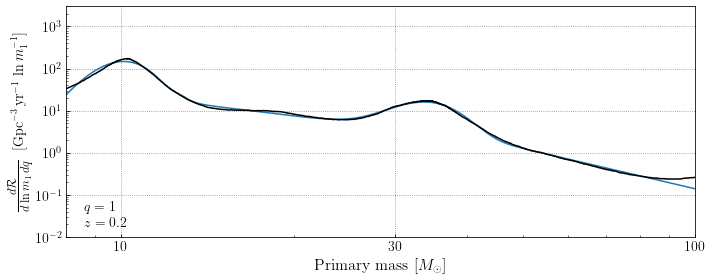

In [6]:
# Finally, plot our fit to double-check that everything is working as intended

# Set up figure
fig,ax = plt.subplots(figsize=(10,4))

# Construct merger rate vs. log-mass corresponding to our least-squares solution
R_m1_model = model(m1s,*soln.x[1:])
R_m1_model_ref = model(20.,*soln.x[1:])
R_m1_model = R_m1_model*(soln.x[0]/R_m1_model_ref)

# Plot this alongside our median AR result
# Note that we're comparing to dR/dlnm1, so we need to multiply our fitted dR/dm1 by m1
ax.plot(m1s,R_m1_model*m1s)
ax.plot(m1s,np.median(dR_dlnm1s,axis=1),color='black')

# Misc figure formatting
ax.tick_params(labelsize=14)
ax.set_xlim(8,100)
ax.set_ylim(1e-2,3e3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([10,30,100])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.text(0.03,0.13,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.03,0.06,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.set_xlabel('Primary mass [$M_\odot$]',fontsize=16)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

plt.tight_layout()
plt.show()

## 3. Plot AR result alongside LVK parametric fit

In [7]:
# Read out the posterior on the merger R(m1,q) as a function of m1 and q, as measured by the LVK
# Below, we will have to do two further things: (i) convert to a merger rate per *log* mass,
# and (ii) evaluate this at our reference mass ratio q=1

lvk_m1_grid,lvk_q_grid,lvk_R_m1s_qs = get_lvk_m1_q(1000)

/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:182: RuntimeWarning: overflow encountered in exp
  q_smoothing[to_smooth] = 1./(np.exp(delta_m/((Q*M)[to_smooth]-mMin) + delta_m/((Q*M)[to_smooth]-mMin-delta_m))+1.)
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:192: RuntimeWarning: invalid value encountered in true_divide
  p_q = p_q_unnormed/np.trapz(p_q_unnormed,q_grid,axis=0)
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:186: RuntimeWarning: divide by zero encountered in power
  p_q_unnormed = Q**bq/(1.-(mMin/M)**(1.+bq))*q_smoothing
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:186: RuntimeWarning: invalid value encountered in multiply
  p_q_unnormed = Q**bq/(1.-(mMin/M)**(1.+bq))*q_smoothing
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/

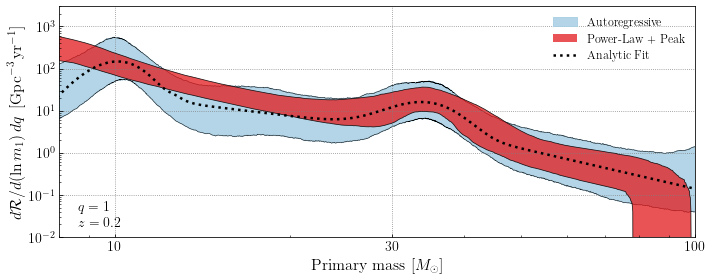

In [8]:
# Set up figure
fig,ax = plt.subplots(figsize=(10,4))
ax.set_rasterization_zorder(2)

# Plot our AR results
ax.plot(m1s,np.quantile(dR_dlnm1s,0.05,axis=1),color='black',lw=0.5,zorder=1)
ax.plot(m1s,np.quantile(dR_dlnm1s,0.95,axis=1),color='black',lw=0.5,zorder=1)
ax.fill_between(m1s,
                np.quantile(dR_dlnm1s,0.05,axis=1),
                np.quantile(dR_dlnm1s,0.95,axis=1),
                color='#a6cee3',alpha=0.85,zorder=-1,
                label='Autoregressive')

# Plot LVK results
# The slicing `lvk_R_m1s_qs[:,-1,:]` pulls out the merger rate at q=1, while we also need to multiply
# by `lvk_m1_grid` to convert to a merger rate per log mass interval
ax.plot(lvk_m1_grid,np.quantile(lvk_R_m1s_qs[:,-1,:],0.05,axis=0)*lvk_m1_grid,color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(lvk_m1_grid,np.quantile(lvk_R_m1s_qs[:,-1,:],0.95,axis=0)*lvk_m1_grid,color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(lvk_m1_grid,
                np.quantile(lvk_R_m1s_qs[:,-1,:],0.05,axis=0)*lvk_m1_grid,
                np.quantile(lvk_R_m1s_qs[:,-1,:],0.95,axis=0)*lvk_m1_grid,
                color='#e31a1c',alpha=0.75,zorder=1,lw=0,
                label='Power-Law + Peak')

# Plot our least-squares fit from above
ax.plot(m1s,R_m1_model*m1s,color='black',ls=':',lw=2.5,label='Analytic Fit')

# Misc figure formatting
ax.tick_params(labelsize=14)
ax.set_xlim(8,100)
ax.set_ylim(1e-2,3e3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([10,30,100])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.legend(loc='upper right')
ax.text(0.03,0.13,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.03,0.06,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.set_xlabel('Primary mass [$M_\odot$]',fontsize=16)
ax.set_ylabel(r'$d\mathcal{R}/d(\ln m_1)\,dq$ \,{[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=16)

plt.tight_layout()
plt.savefig('figure_03b.pdf',bbox_inches='tight',dpi=200)
plt.show()